In [1]:
import sys

sys.path.append("../")
from config.get_config import get_config

# Load Data

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import mlflow

from sklearn.metrics import mean_squared_error

In [3]:
sys.path.append("../src")
from pipeline.factory import Factory
from preprocessing.process_raw_data import load_data

config = dict(get_config())
data_config = dict(config["data"])

mlflow.set_tracking_uri("http://0.0.0.0:5000")
e = mlflow.set_experiment(data_config["mlflow_experiment_name"])

2024-02-07 11:52:18.288501: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-07 11:52:18.320330: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 11:52:18.320358: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 11:52:18.320373: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-07 11:52:18.327589: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-07 11:52:18.328587: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [4]:
# fix paths
for k, v in data_config["paths"].items():
    if k == "scaler" or k == "optim":
        continue
    for k2, v2 in v.items():
        data_config["paths"][k][k2] = "../" + v2

In [5]:
df = load_data(data_config["paths"])
f = Factory(data_config)
f.fit(df)

Fitting data ...


/home/acaille/.cache/pypoetry/virtualenvs/stores-sales-forecasting-poc-oU5uZx8Y-py3.10/lib/python3.10/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/acaille/.cache/pypoetry/virtualenvs/stores-sales-forecasting-poc-oU5uZx8Y-py3.10/lib/python3.10/site-packages/pandas/core/generic.py:6915: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


## Data Viz

In [6]:
train, val = f.get_df()
data = pd.concat([train, val])

In [7]:
train.head()

,onpromotion,dcoilwtico,cluster,sales,typedays_Additional,typedays_Event,typedays_Holiday,typedays_Normal
2013-01-01,0.0,0.792965,0.0,2511.618999,False,False,True,False
2013-01-02,0.0,0.792965,0.0,496092.417944,False,False,False,True
2013-01-03,0.0,0.790951,0.0,361461.231124,False,False,False,True
2013-01-04,0.0,0.792728,0.0,354459.677093,False,False,False,True
2013-01-05,0.0,0.793044,0.0,348347.385084,False,False,False,True


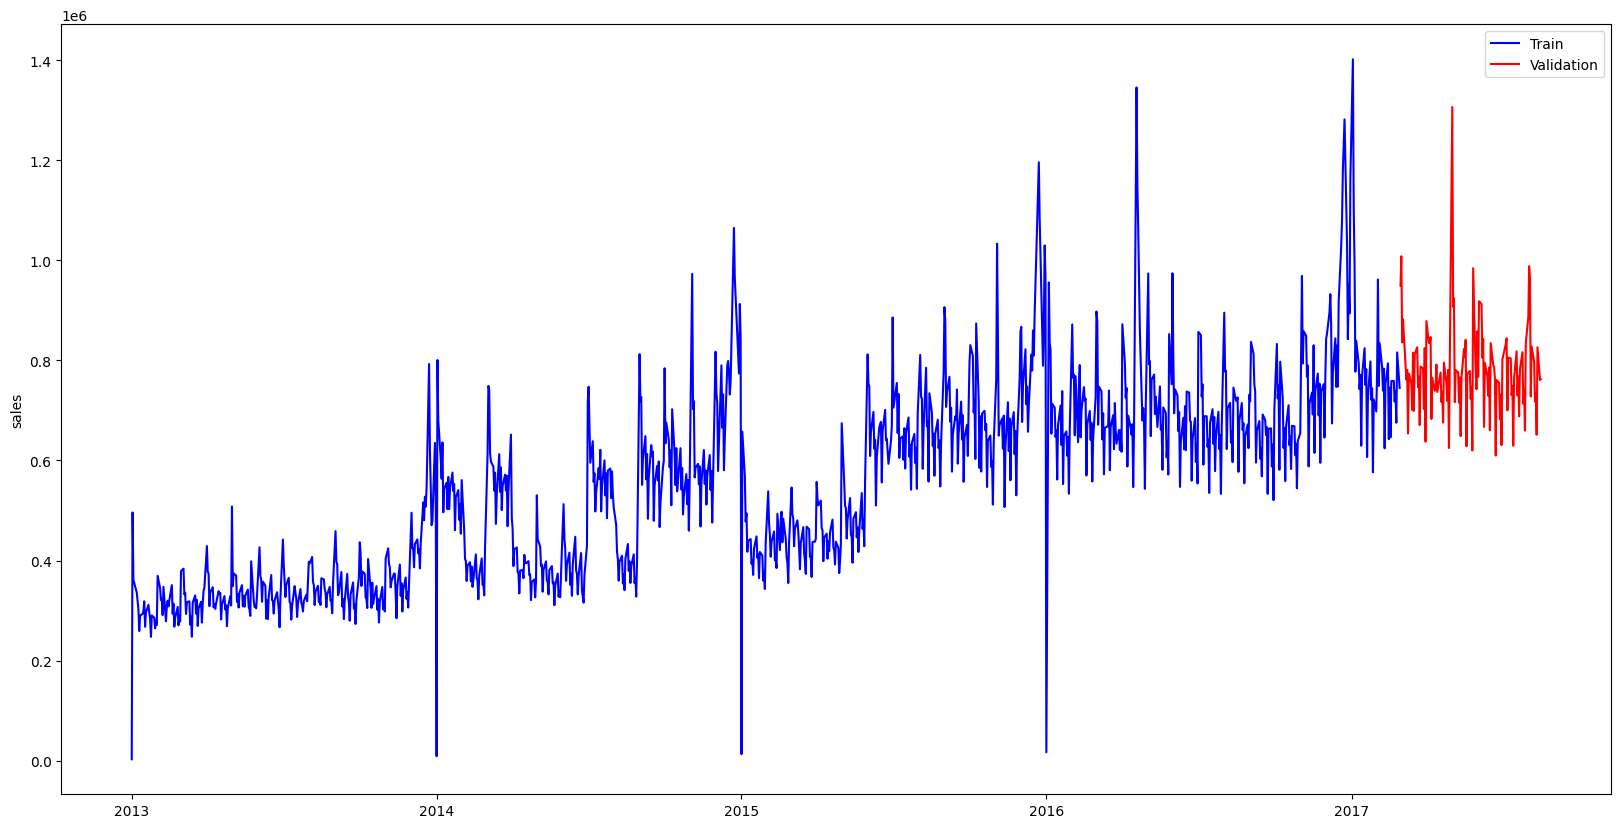

In [8]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=train, x=train.index, y="sales", color="blue", label="Train")
sns.lineplot(data=val, x=val.index, y="sales", color="red", label="Validation")
plt.legend()

# Models fit

In [9]:
def predict_and_plot(model_name):
    model_type = model_name.split(" ")[0]
    model = model_name.split(" ")[1]
    id = (
        mlflow.search_registered_models(filter_string=f"name = '{model_name}'")[0]
        .latest_versions[0]
        .run_id
    )
    local_config = config[model_type][model]

    f.load_model(id, local_config)
    pred = f.predict()

    print(f"Predicted {len(pred)} days")

    assert len(pred) == len(val)

    df = pd.DataFrame(pred, columns=["yhat"])
    plt.figure(figsize=(20, 10))
    sns.lineplot(
        data=df, x=val.index, y="yhat", color="red", label=f"{model_type} Prediction"
    )
    sns.lineplot(data=val, x=val.index, y="sales", color="blue", label="Validation")

    print(f"RMSE: {mean_squared_error(val['sales'], pred)}")
    
    return pred

# Best Model Analysis

## Xgboost without earthquake features

Predicted 169 days
RMSE: 4151140927.416664


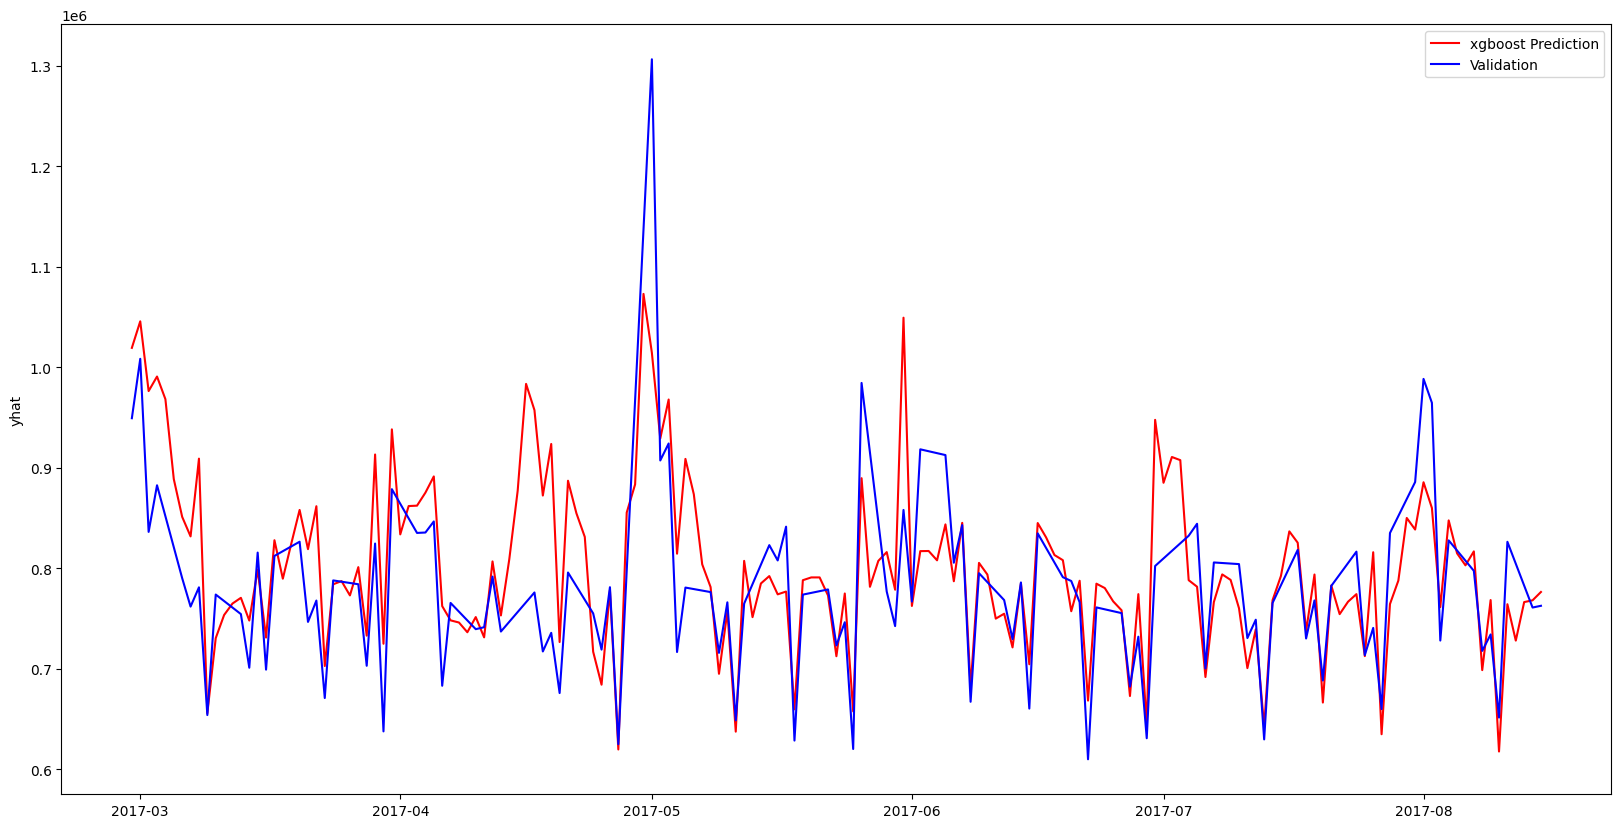

In [10]:
pred = predict_and_plot("xgboost best_params - 2024-02-01 21:24")

## Xgboost with earthquake features

Predicted 169 days
RMSE: 3353398434.5180197


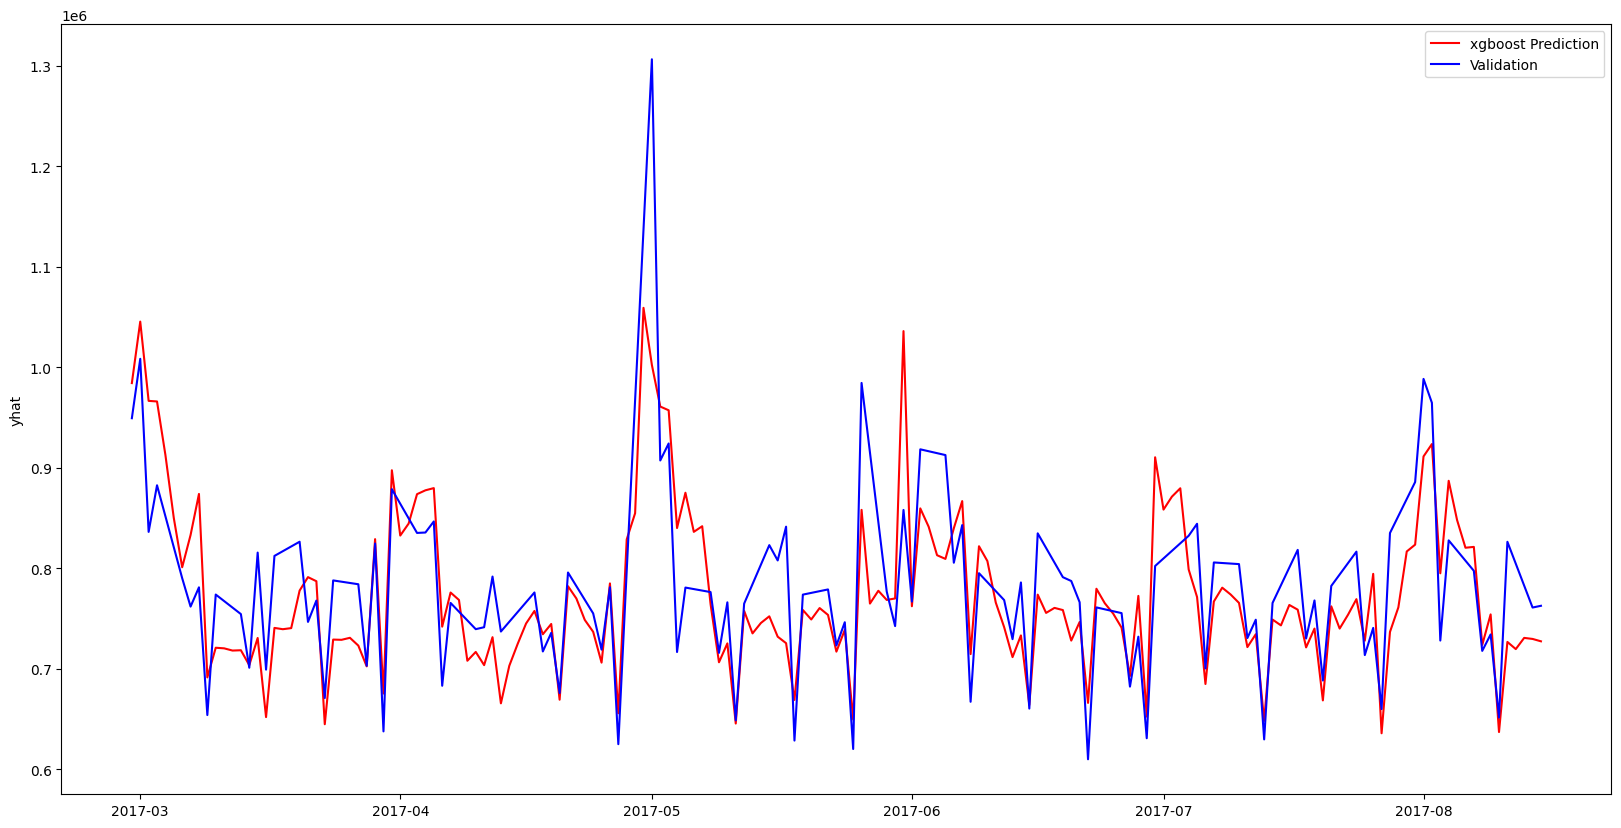

In [11]:
pred = predict_and_plot("xgboost best_params_earthquake - 2024-02-07 10:23")

In [14]:
val_with_pred = val.copy()
val_with_pred["pred"] = pred

val_with_pred = val_with_pred[(val_with_pred.index >= "2017-06-01") & (val_with_pred.index < "2017-08-01")][["sales", "pred"]]
val_with_pred['diff'] = val_with_pred['sales'] - val_with_pred['pred']
val_with_pred.where(val_with_pred['diff'] < 0).dropna().sort_values(by='diff')

,sales,pred,diff
2017-06-30,802273.139233,910488.8750,-108215.735767
2017-06-22,609868.830959,666003.0625,-56134.231541
2017-07-03,824837.749318,879646.9375,-54809.188182
2017-07-02,817316.212623,871299.7500,-53983.537377
2017-07-26,740653.044167,794453.2500,-53800.205833
2017-07-01,809794.675928,858416.0000,-48621.324072
2017-06-08,667099.801025,714578.9375,-47479.136475
2017-06-28,731896.985010,772519.3750,-40622.389990
2017-06-06,805546.647956,839873.5625,-34326.914544
2017-06-09,795116.136070,821943.3750,-26827.238930


In [18]:
val["2017-06-30":]

,onpromotion,dcoilwtico,cluster,sales,typedays_Additional,typedays_Event,typedays_Holiday,typedays_Normal
2017-06-30,0.679238,0.234869,0.0,802273.139233,False,False,False,True
2017-07-01,0.647993,0.233522,0.0,809794.675928,False,False,False,True
2017-07-02,0.616749,0.232175,0.0,817316.212623,False,False,False,True
2017-07-03,0.585505,0.230827,0.0,824837.749318,False,False,False,True
2017-07-04,0.554261,0.229480,0.0,832359.286014,False,False,False,True
2017-07-05,0.858084,0.224091,0.0,844301.613116,False,False,False,True
2017-07-06,0.491121,0.228947,0.0,700272.009957,False,False,False,True
2017-07-07,0.688172,0.213905,0.0,805792.302193,False,False,False,True
2017-07-08,0.610662,0.214497,0.0,805247.821807,False,False,False,True
2017-07-09,0.533152,0.215089,0.0,804703.341422,False,False,False,True
